# Classification Algorithms

This notebook contains a few classification machine learning algorithms such as K Nearest Neighbor(KNN), Decision Tree, Support Vector Machine, Logistic Regression.

The goal is to find the best one for this specific dataset by accuracy evaluation methods.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import itertools
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from matplotlib.ticker import NullFormatter
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier

from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus
import matplotlib.image as mpimg

from sklearn import svm

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

%matplotlib inline

### Data

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-09-01 00:16:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.08s   

2020-09-01 00:16:20 (299 KB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection.

Let's plot some columns to understand data better:

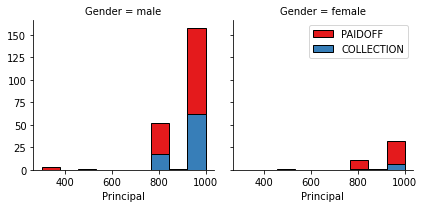

In [8]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

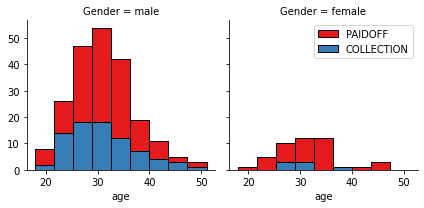

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

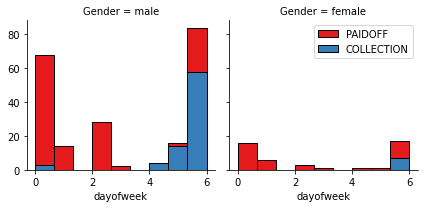

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

People who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold values less than day 4.

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 0 if (x<4)  else 1)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Gender distribution:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Converting male to 0 and female to 1:

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
Education distribution:

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Lables

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization gives data zero mean and unit variance (technically should be done after train test split)

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor(KNN)

#### create train and test sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
print('Train set: ', X_train.shape, y_train.shape)
print('test set: ', X_test.shape, y_test.shape)

Train set:  (276, 8) (276,)
test set:  (70, 8) (70,)


#### create KNN model and choose a better k

In [21]:
k_max = 10
mean_acc = np.zeros(k_max-1)
std_acc = np.zeros(k_max-1)

for i in range(1,k_max):
    KNN = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    y_hat = KNN.predict(X_test)
    mean_acc[i-1] = metrics.accuracy_score(y_test, y_hat)
    std_acc[i-1] = np.std(y_hat == y_test)/np.sqrt(y_hat.shape[0])
mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

#### Better k = 7 with accuracy 0.78

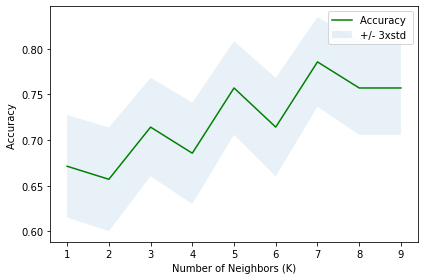

In [22]:
plt.plot(range(1,k_max),mean_acc,'g')
plt.fill_between(range(1,k_max),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

Train model at all data

In [23]:
KNN = KNeighborsClassifier(n_neighbors = 7).fit(X, y)

# Decision Tree

In [24]:
depth = 10
mean_acc_tree = np.zeros(depth-1)

for n in range(1, depth):
    Tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = n)
    Tree.fit(X_train, y_train)
    y_hat = Tree.predict(X_test)
    mean_acc_tree[n-1] = metrics.accuracy_score(y_test, y_hat)
mean_acc_tree

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.64285714,
       0.77142857, 0.75714286, 0.75714286, 0.65714286])

#### Optimal depth = 2 with accuracy 0.78

In [25]:
Tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)

In [26]:
Tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
y_hatTree = Tree.predict(X_test)

In [28]:
metrics.accuracy_score(y_test, y_hatTree)

0.7857142857142857

Train model to all data

In [29]:
Tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
df.columns[0:5]

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms'], dtype='object')

In [31]:
Feature.columns[0:8]

Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')

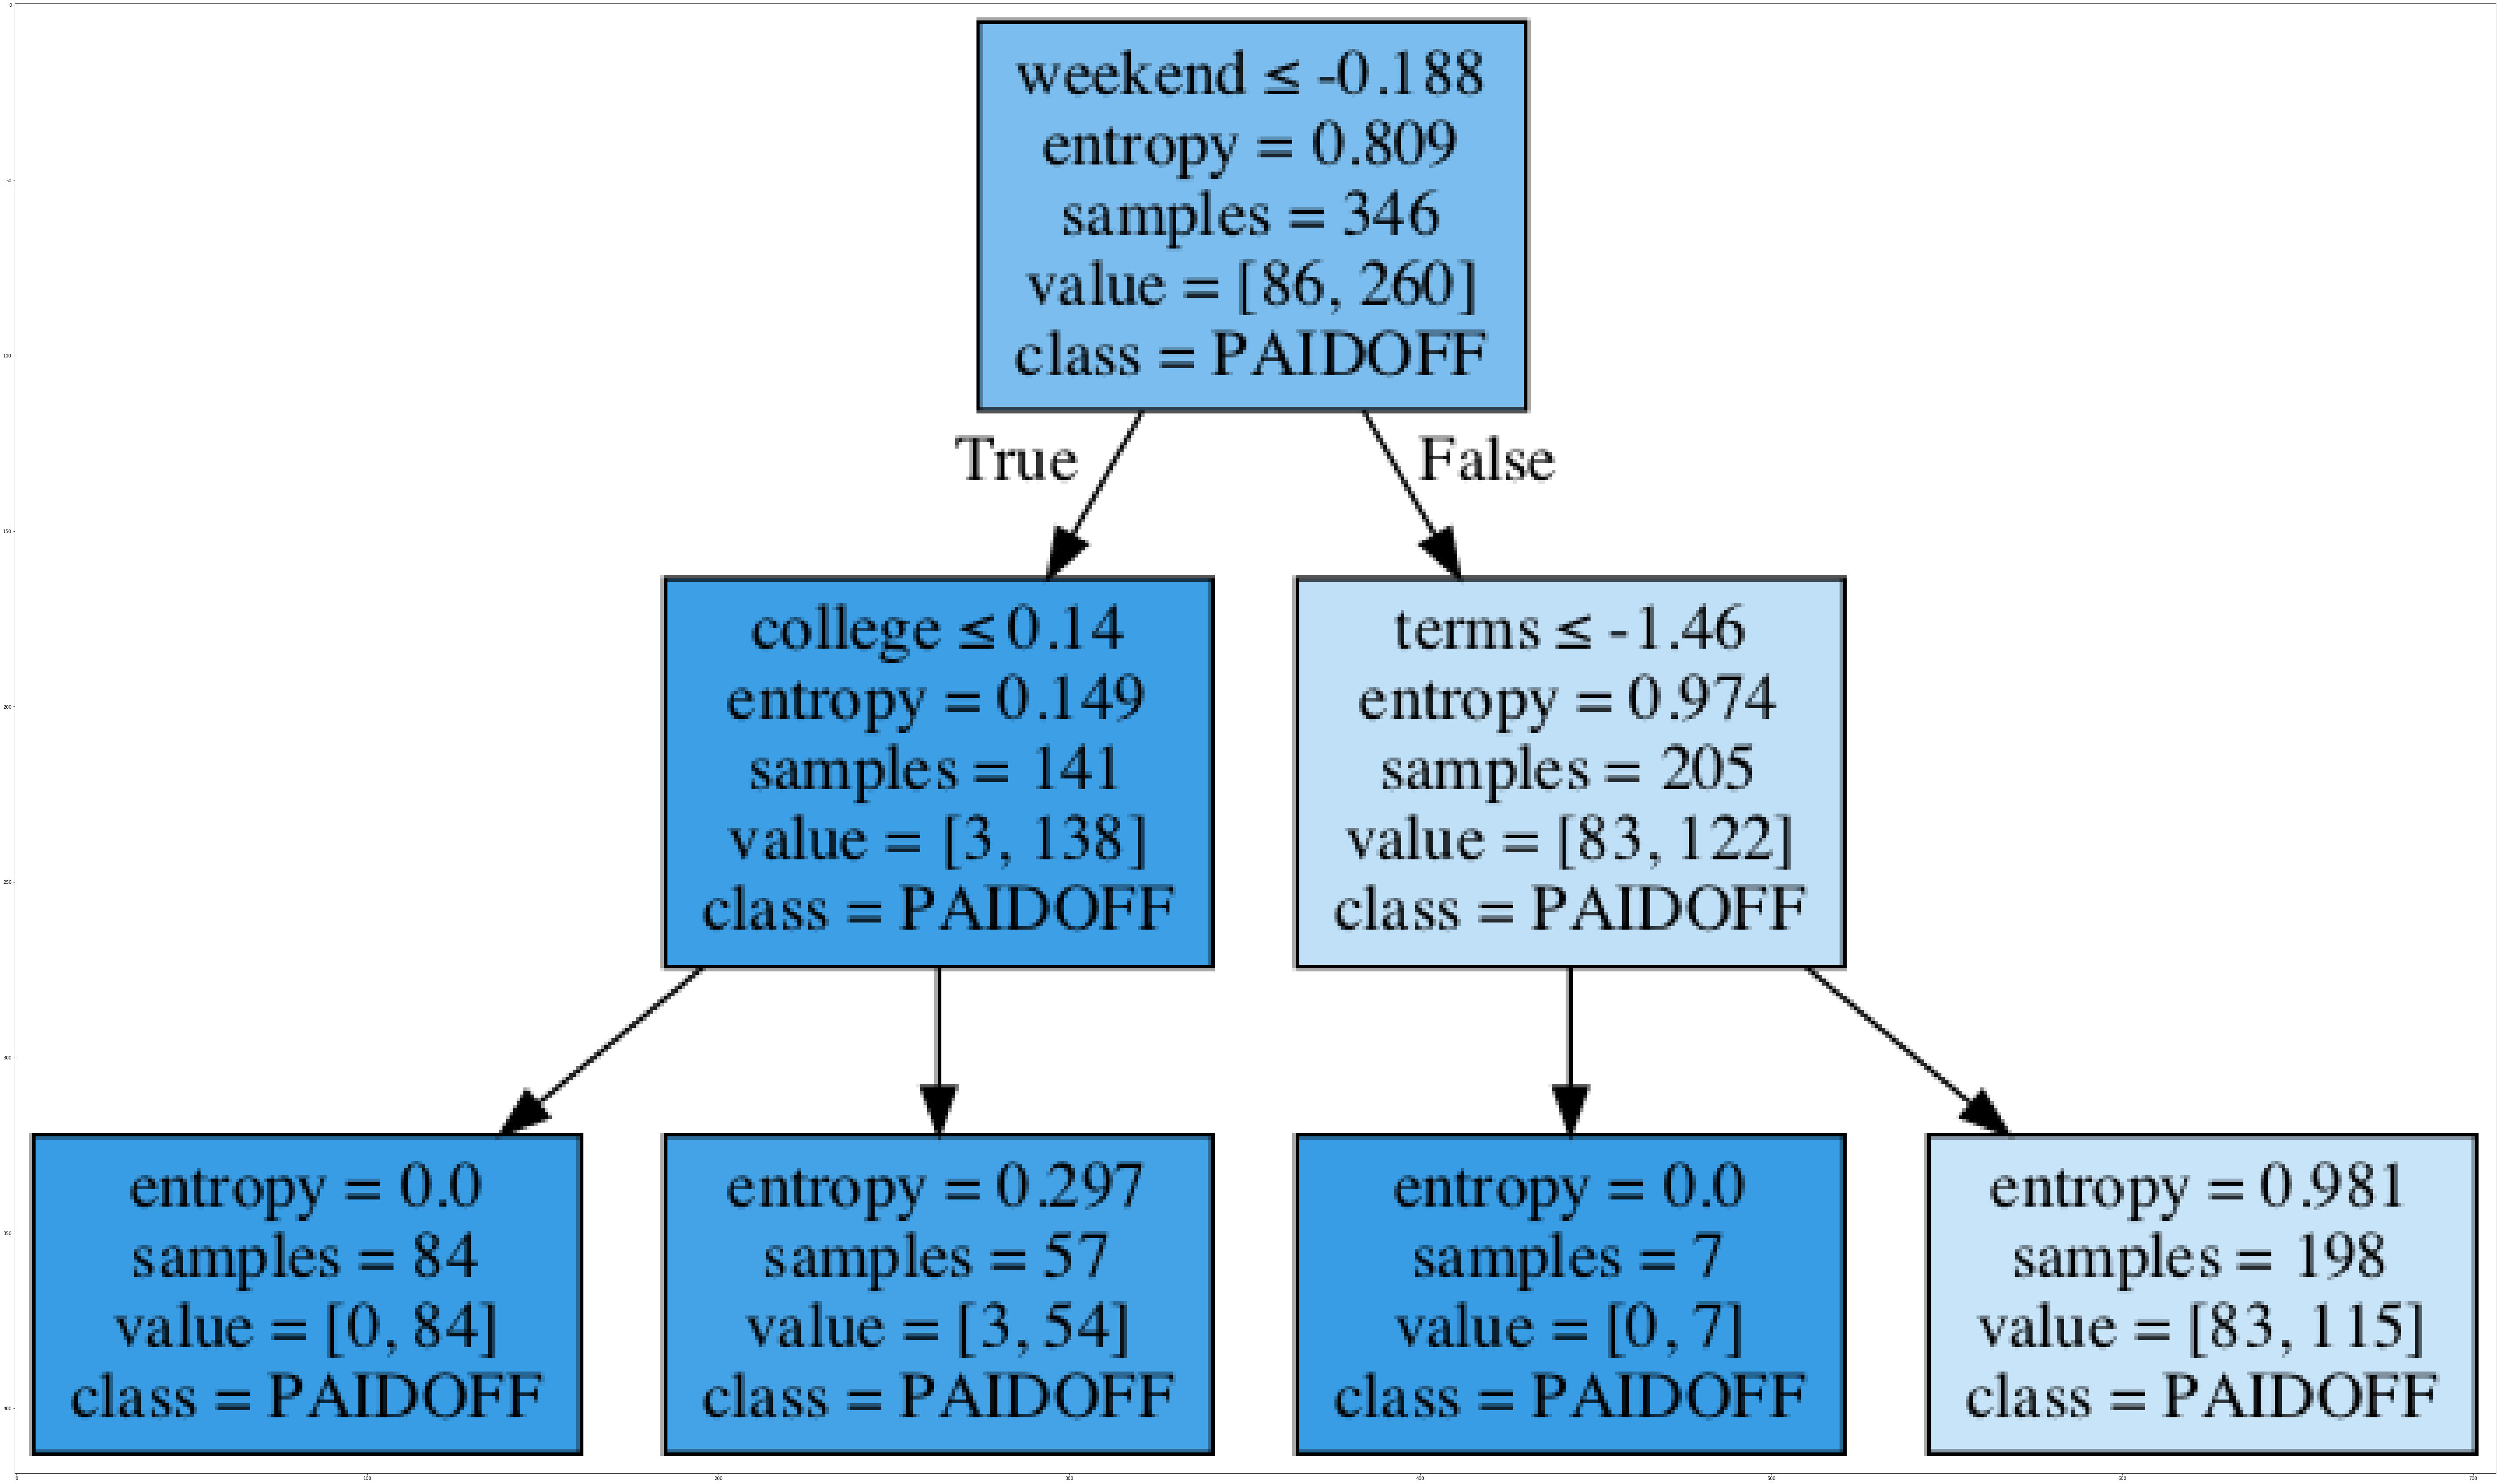

In [32]:
#visualize
dot_data = StringIO()
filename = "tree3.png"
featureNames = Feature.columns[0:9]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(Tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [33]:
SVM = svm.SVC(kernel='rbf', gamma = 'auto')
SVM.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
y_hat_SVC = SVM.predict(X_test)

In [35]:
metrics.accuracy_score(y_test, y_hat_SVC)

0.7428571428571429

In [36]:
kernels = ['linear', "poly", 'rbf', 'sigmoid', 'precomputed']
mean_acc_SVC = np.zeros(len(kernels)-1)
for i in range(0,len(kernels)-1):
    SVM = svm.SVC(kernel=kernels[i] , gamma = 'auto')
    SVM.fit(X_train, y_train)
    y_hat = SVM.predict(X_test)
    mean_acc_SVC[i] = metrics.accuracy_score(y_test, y_hat)
mean_acc_SVC

array([0.78571429, 0.77142857, 0.74285714, 0.74285714])

#### How we can see linear model have better accuracy

In [37]:
#train model to hole dataset
SVM = svm.SVC(kernel='linear', gamma = 'auto')
SVM.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Logistic Regression

In [38]:
LR = LogisticRegression(solver='liblinear')
LR.fit(X_train, y_train)
y_hat_LR = LR.predict(X_test)
metrics.accuracy_score(y_test, y_hat_LR)

0.7142857142857143

In [39]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
mean_acc_lr = np.zeros(len(solvers))
for counter, value in enumerate(solvers):
    LR = LogisticRegression(solver = value);
    LR.fit(X_train, y_train)
    y_hat_LR = LR.predict(X_test)
    mean_acc_lr[counter] = metrics.accuracy_score(y_test, y_hat_LR)
mean_acc_lr

array([0.72857143, 0.72857143, 0.71428571, 0.72857143, 0.72857143])

In [40]:
y_prob = LR.predict_proba(X_test)
y_prob[0:10]

array([[0.51845667, 0.48154333],
       [0.38661504, 0.61338496],
       [0.02326668, 0.97673332],
       [0.03501258, 0.96498742],
       [0.02344788, 0.97655212],
       [0.02733013, 0.97266987],
       [0.45664813, 0.54335187],
       [0.41605724, 0.58394276],
       [0.03501258, 0.96498742],
       [0.45828616, 0.54171384]])

In [41]:
from sklearn.metrics import log_loss
log_loss(y_test, y_prob)

0.500111663072369

#### we can use default setting for solver

In [42]:
LR = LogisticRegression(solver = 'lbfgs')
LR.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluation using Test set

In [43]:
from sklearn.metrics import jaccard_similarity_score

First, download and load the test set:

In [44]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-09-01 00:16:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-09-01 00:16:28 (204 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation 

In [45]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [46]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [47]:
X_test = Feature_test
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [48]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Creatind Data Frame with all metrics

In [49]:
columns = ['Algorithm','Jaccard', 'F1-score', 'LogLoss']
results = pd.DataFrame({'Algorithm' : ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']}, columns = columns)
results

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,NaN,NaN,NaN
1,Decision Tree,NaN,NaN,NaN
2,SVM,NaN,NaN,NaN
3,Logistic Regression,NaN,NaN,NaN


# Results


In [50]:
from sklearn.metrics import classification_report

In [51]:
names = [KNN, Tree, SVM, LR]
for counter, value in enumerate(names):
    y_hat = value.predict(X_test)
    results['Jaccard'][counter] = jaccard_similarity_score(y_test, y_hat)
    results['F1-score'][counter] = f1_score(y_test, y_hat, average='weighted')
    print(names[counter])
    print(classification_report(y_test, y_hat))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

  COLLECTION       0.44      0.29      0.35        14
     PAIDOFF       0.78      0.88      0.82        40

    accuracy                           0.72        54
   macro avg       0.61      0.58      0.59        54
weighted avg       0.69      0.72      0.70        54

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

  CO

In [52]:
results['LogLoss'][3] = log_loss(y_test, LR.predict_proba(X_test))

In [53]:
results

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.722222,0.700199,NaN
1,Decision Tree,0.740741,0.630418,NaN
2,SVM,0.740741,0.630418,NaN
3,Logistic Regression,0.759259,0.671764,0.480808


### All evaluation metrics are almost the same. 
##### Jaccard score higher is better - LR
##### F1-score higher is better - KNN
##### LogLoss lower is of higher accuracy.